In [1]:
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, mean_absolute_percentage_error
from matplotlib import pyplot as plt
from torchinfo import summary
from ptflops import get_model_complexity_info

seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [2]:
class SVDDecomposedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, rank_approx):
        super(SVDDecomposedLSTM, self).__init__()
        self.rank_approx = rank_approx
        self.hidden_size = hidden_size

        # 创建分解权重参数
        self.lstm1_ih_u = nn.Parameter(torch.Tensor(4*hidden_size, rank_approx))
        self.lstm1_ih_s = nn.Parameter(torch.Tensor(rank_approx))
        self.lstm1_ih_v = nn.Parameter(torch.Tensor(rank_approx, input_size))

        self.lstm1_hh_u = nn.Parameter(torch.Tensor(4*hidden_size, rank_approx))
        self.lstm1_hh_s = nn.Parameter(torch.Tensor(rank_approx))
        self.lstm1_hh_v = nn.Parameter(torch.Tensor(rank_approx, hidden_size))

        self.lstm2_ih_u = nn.Parameter(torch.Tensor(4*hidden_size, rank_approx))
        self.lstm2_ih_s = nn.Parameter(torch.Tensor(rank_approx))
        self.lstm2_ih_v = nn.Parameter(torch.Tensor(rank_approx, hidden_size))

        self.lstm2_hh_u = nn.Parameter(torch.Tensor(4*hidden_size, rank_approx))
        self.lstm2_hh_s = nn.Parameter(torch.Tensor(rank_approx))
        self.lstm2_hh_v = nn.Parameter(torch.Tensor(rank_approx, hidden_size))

        self.fc_u = nn.Parameter(torch.Tensor(output_size, rank_approx))
        self.fc_s = nn.Parameter(torch.Tensor(rank_approx))
        self.fc_v = nn.Parameter(torch.Tensor(rank_approx, hidden_size))

        self.fc_bias = nn.Parameter(torch.zeros(output_size))  # 全连接层偏置

        self.init_weights()

    def init_weights(self):
        # 初始化参数
        stdv = 1.0 / torch.sqrt(torch.tensor(self.hidden_size, dtype=torch.float))
        for param in self.parameters():
            param.data.uniform_(-stdv, stdv)

    def forward(self, x, hidden=None):
        batch_size = x.size(0)
        if hidden is None:
            # 动态初始化隐藏状态
            hidden = ((torch.zeros(batch_size, self.hidden_size, device=x.device),
                       torch.zeros(batch_size, self.hidden_size, device=x.device)),
                      (torch.zeros(batch_size, self.hidden_size, device=x.device),
                       torch.zeros(batch_size, self.hidden_size, device=x.device)))

        hx1, cx1 = hidden[0]
        hx2, cx2 = hidden[1]

        # 使用分解后的权重重建原始权重进行计算
        w_ih1 = torch.mm(self.lstm1_ih_u, torch.mm(torch.diag(self.lstm1_ih_s), self.lstm1_ih_v))
        w_hh1 = torch.mm(self.lstm1_hh_u, torch.mm(torch.diag(self.lstm1_hh_s), self.lstm1_hh_v))
        hx1, cx1 = self.custom_lstm_cell(x, (hx1, cx1), w_ih1, w_hh1)

        w_ih2 = torch.mm(self.lstm2_ih_u, torch.mm(torch.diag(self.lstm2_ih_s), self.lstm2_ih_v))
        w_hh2 = torch.mm(self.lstm2_hh_u, torch.mm(torch.diag(self.lstm2_hh_s), self.lstm2_hh_v))
        hx2, cx2 = self.custom_lstm_cell(hx1, (hx2, cx2), w_ih2, w_hh2)

        w_fc = torch.mm(self.fc_u, torch.mm(torch.diag(self.fc_s), self.fc_v))
        out = torch.addmm(self.fc_bias, hx2, w_fc.t())

        return out, ((hx1, cx1), (hx2, cx2))

    def custom_lstm_cell(self, input, hidden, w_ih, w_hh, b_ih=None, b_hh=None):
        hx, cx = hidden  # hx 和 cx 都应该是 [batch_size, hidden_size]

        # 确保 input 和 hx 是二维的且具有正确的尺寸
        if input.dim() == 3:
            input = input.view(-1,
                               input.size(2))  # 假设 input 的形状为 [batch_size, 1, input_size]，平展为 [batch_size, input_size]
        if hx.dim() == 3:
            hx = hx.view(-1, hx.size(2))  # 假设 hx 的形状为 [batch_size, 1, hidden_size]，平展为 [batch_size, hidden_size]

        # 应用线性变换
        gates = F.linear(input, w_ih, b_ih) + F.linear(hx, w_hh, b_hh)  # gates 应该是 [batch_size, 4*hidden_size]

        # 分割门控制向量
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)

        # 激活函数
        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)

        cy = (forgetgate * cx) + (ingate * cellgate)
        hy = outgate * torch.tanh(cy)

        return hy, cy

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [3]:
def load_and_preprocess_data():
    df = pd.read_csv('data/jena_climate.csv')
    scaler = StandardScaler()
    dataset = scaler.fit_transform(df[['Tpot (K)', 'wd (deg)', 'VPact (mbar)', 'sh (g/kg)',
                                       'H2OC (mmol/mol)', 'rho (g/m**3)', 'p (mbar)']].values)
    return dataset

In [4]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1][0][0]  # predict the next value
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [5]:
# Parameters
input_size = 7
hidden_size = 128
output_size = 1

timesteps = 1
batch_size = 16
epochs = 50

rank_approx=35

In [6]:
# Load data
data = load_and_preprocess_data()
train_size = int(len(data) * 0.8)

train_data = data[:train_size]
test_data = data[train_size:]

# Create sequences
train_sequences = create_inout_sequences(train_data, timesteps)
test_sequences = create_inout_sequences(test_data, timesteps)

# Dataloaders
train_dataset = TensorDataset(torch.tensor([i[0] for i in train_sequences], dtype=torch.float32), torch.tensor([i[1] for i in train_sequences], dtype=torch.float32))
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

test_dataset = TensorDataset(torch.tensor([i[0] for i in test_sequences], dtype=torch.float32), torch.tensor([i[1] for i in test_sequences], dtype=torch.float32))
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

C:\Users\Lcw\AppData\Local\Temp\ipykernel_19704\1434566981.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  train_dataset = TensorDataset(torch.tensor([i[0] for i in train_sequences], dtype=torch.float32), torch.tensor([i[1] for i in train_sequences], dtype=torch.float32))


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SVDDecomposedLSTM(input_size, hidden_size, output_size, rank_approx).to(device)
print(summary(model))

Layer (type:depth-idx)                   Param #
SVDDecomposedLSTM                        90,056
Total params: 90,056
Trainable params: 90,056
Non-trainable params: 0


In [8]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

train_losses = []  # Initialize lists to record training losses
test_losses = []  # Initialize lists to record test losses
start_time = time.time()  # record time

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output, _ = model(x)
        loss = criterion(output, y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Record average loss for this epoch
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Evaluate on test set
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            output, _ = model(x)
            loss = criterion(output, y.unsqueeze(1))
            total_test_loss += loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch + 1}, Train Loss: {avg_loss}, Test Loss: {avg_test_loss}")

end_time = time.time()
print("Total Train program time:%f" % (end_time - start_time)) #Total Train program time:76.490338

torch.save(model.state_dict(),'modelCache/SVDLSTM_rank35.pth')

Epoch 1, Train Loss: 0.08276056314415992, Test Loss: 0.006700214144337224
Epoch 2, Train Loss: 0.0017134918197081169, Test Loss: 0.0021784200869005873
Epoch 3, Train Loss: 0.0014483821857296123, Test Loss: 0.012621123004413676
Epoch 4, Train Loss: 0.0013697567059703592, Test Loss: 0.002095264514508017
Epoch 5, Train Loss: 0.0013490971223318383, Test Loss: 0.0017235328919196036
Epoch 6, Train Loss: 0.001230821115851912, Test Loss: 0.0014907810295408126
Epoch 7, Train Loss: 0.0012737411873401854, Test Loss: 0.001415020135231316
Epoch 8, Train Loss: 0.0014190970854084757, Test Loss: 0.0018719478385755793
Epoch 9, Train Loss: 0.0013096004426457243, Test Loss: 0.0013934196850314037
Epoch 10, Train Loss: 0.0011764583555400254, Test Loss: 0.0024725443089846522
Epoch 11, Train Loss: 0.0011523916111325964, Test Loss: 0.0013290532558821724
Epoch 12, Train Loss: 0.0012011818395770311, Test Loss: 0.0018874714320554632
Epoch 13, Train Loss: 0.0011753028417545762, Test Loss: 0.0013931880276213634
Ep

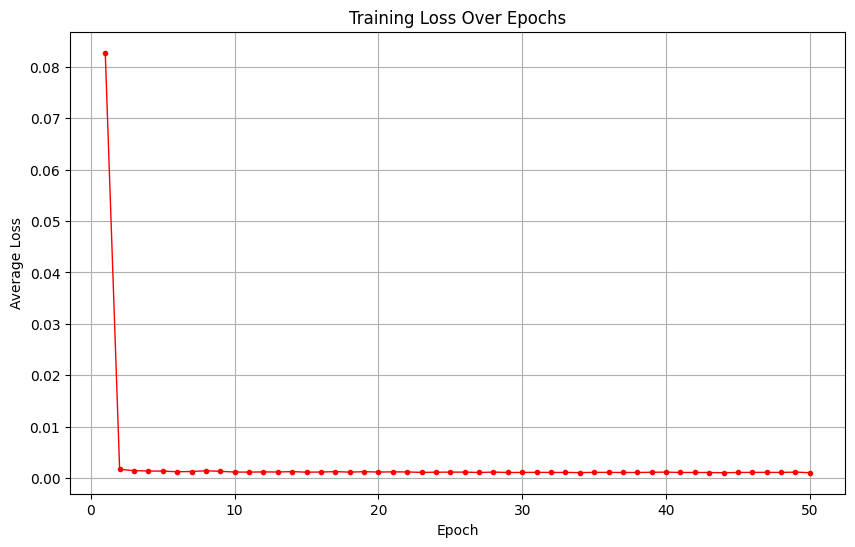

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, marker='.', linestyle='-',linewidth=1, color='red')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.savefig('image_result/SVD-LSTM_training_loss_rank35.eps', bbox_inches='tight')
plt.show()

In [10]:
# Prediction and Evaluation
model.eval()  # Set the model to evaluation mode

# Generate predictions and calculate prediction loss
prediction_losses = []
predictions = []
true_values = []
start_time = time.time()
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        output, _ = model(x)
        predictions.extend(output.cpu().numpy())
        true_values.extend(y.cpu().numpy())
        loss = criterion(output, y.unsqueeze(1))
        prediction_losses.append(loss.item())
end_time = time.time()
print("Total test time:%f" % (end_time - start_time)) #Total test time:0.784137

Total test time:0.588603


In [11]:
avg_prediction_loss = np.mean(prediction_losses)

In [12]:
# Evaluate predictions
mse = mean_squared_error(true_values, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values, predictions)
r2 = r2_score(true_values, predictions)
evs = explained_variance_score(true_values, predictions)
mape = mean_absolute_percentage_error(true_values, predictions)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")
print(f"Explained Variance Score: {evs}")
print(f"Mean Absolute Percentage Error: {mape}")
print(f"Prediction Loss: {avg_prediction_loss}")

Mean Squared Error: 0.0013602306134998798
Root Mean Squared Error: 0.036881305277347565
Mean Absolute Error: 0.026025520637631416
R^2 Score: 0.9962209677310461
Explained Variance Score: 0.9962338209152222
Mean Absolute Percentage Error: 0.06048453599214554
Prediction Loss: 0.0013602305670065108


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


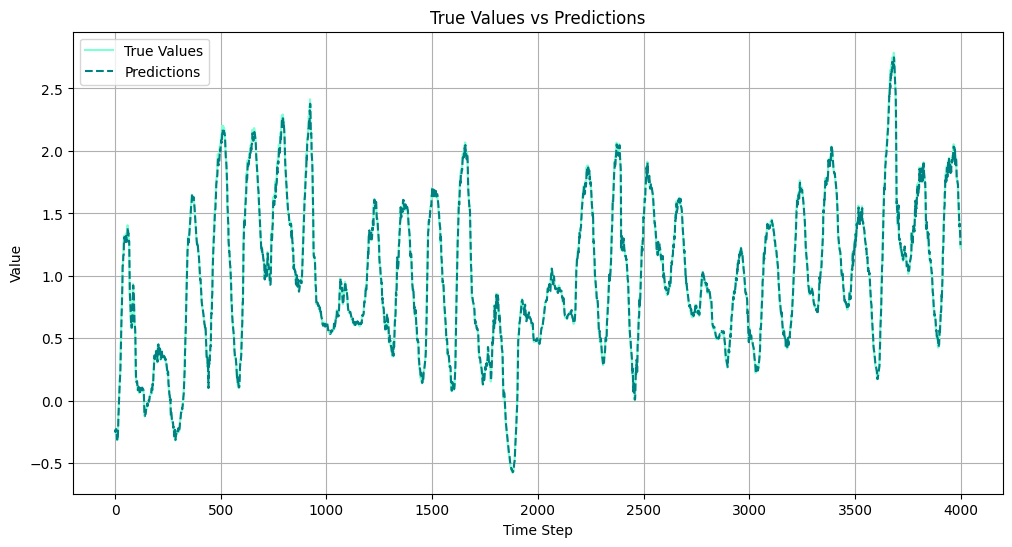

In [13]:
# Plot predictions vs true values
plt.figure(figsize=(12, 6))
plt.plot(true_values, label='True Values', color='aquamarine')
plt.plot(predictions, label='Predictions', color='teal', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('True Values vs Predictions')
plt.legend()
plt.grid(True)
plt.savefig('image_result/SVD-LSTM_predictions_vs_true_rank35.eps', bbox_inches='tight')
plt.show()

In [14]:
# The PTFLOPS library can not handle custom LSTM units properly.
# To solve this problem, we can try to calculate FLOPs and Macs manually and 
# make sure that the operation of the custom LSTM unit is consistent with the standard LSTM unit.

def calculate_flops_and_macs():
    # LSTM层的FLOPs和MACs计算
    def lstm_flops_and_macs(input_size, hidden_size, rank_approx):
        flops = 0
        macs = 0
        # input-hidden部分的FLOPs和MACs
        flops += 4 * (2 * input_size * rank_approx + 2 * rank_approx * hidden_size)
        macs += 4 * (input_size * rank_approx + rank_approx * hidden_size)
        # hidden-hidden部分的FLOPs和MACs
        flops += 4 * (2 * hidden_size * rank_approx + 2 * rank_approx * hidden_size)
        macs += 4 * (hidden_size * rank_approx + rank_approx * hidden_size)
        return flops, macs

    # 全连接层的FLOPs和MACs计算
    def fc_flops_and_macs(hidden_size, output_size, rank_approx):
        flops = 2 * (hidden_size * rank_approx + rank_approx * output_size)
        macs = hidden_size * rank_approx + rank_approx * output_size
        return flops, macs

    total_flops = 0
    total_macs = 0
    # 计算每层的FLOPs和MACs
    flops, macs = lstm_flops_and_macs(input_size, hidden_size, rank_approx)
    total_flops += flops
    total_macs += macs

    flops, macs = lstm_flops_and_macs(hidden_size, hidden_size, rank_approx)
    total_flops += flops
    total_macs += macs

    flops, macs = fc_flops_and_macs(hidden_size, output_size, rank_approx)
    total_flops += flops
    total_macs += macs

    return total_flops, total_macs

flops, macs = calculate_flops_and_macs()
mflops = flops / 1e6
mmacs = macs / 1e6

print(f'FLOPs: {flops / 1e6:.7f} MFLOPs')
print(f"Total MACs: {macs}")
# print(f"Total MMACs: {mmacs}")

total_params = sum(p.numel() for p in model.parameters())
print(f'Number of parameters: {total_params}')

FLOPs: 0.2618700 MFLOPs
Total MACs: 130935
Number of parameters: 90056
